In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve

warnings.filterwarnings('ignore')

In [2]:
# to read all the column names
pd.set_option('display.max_columns', None)

### Reading and understanding data

In [3]:
leads = pd.read_csv("Leads.csv")

In [4]:
leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [5]:
# Dropping 'Prospect ID', 'Lead Number' as its not needed
# Dropping Last Activity as a similar column exists
leads.drop(['Prospect ID', 'Lead Number', 'Last Activity'], axis=1, inplace=True)

#### Change column names

In [6]:
leads.rename(columns={'Total Time Spent on Website':'total_time_spent', 'Page Views Per Visit':'views_per_visit', 
                   'How did you hear about X Education':'hear_from', 'What is your current occupation':'Occupation',
                   'What matters most to you in choosing a course':'X_Factor',
                   'Receive More Updates About Our Courses': 'should_receive_updates',
                   'Update me on Supply Chain Content': 'update_supply_chain_content' ,
                   'Get updates on DM Content': 'update_DM_content',
                   'I agree to pay the amount through cheque': 'is_cheque',
                   'A free copy of Mastering The Interview': 'copy_msting_interview'}, inplace=True)

In [7]:
o_shape = leads.shape
o_shape

(9240, 34)

In [8]:
percent_missing_info = (leads.isnull().sum() * 100 / leads.shape[0]).sort_values(ascending=False)
percent_missing_info

Lead Quality                   51.590909
Asymmetrique Profile Score     45.649351
Asymmetrique Activity Score    45.649351
Asymmetrique Profile Index     45.649351
Asymmetrique Activity Index    45.649351
Tags                           36.287879
Lead Profile                   29.318182
X_Factor                       29.318182
Occupation                     29.112554
Country                        26.634199
hear_from                      23.885281
Specialization                 15.562771
City                           15.367965
views_per_visit                 1.482684
TotalVisits                     1.482684
Lead Source                     0.389610
Last Notable Activity           0.000000
total_time_spent                0.000000
Converted                       0.000000
Do Not Email                    0.000000
Do Not Call                     0.000000
X Education Forums              0.000000
Search                          0.000000
Magazine                        0.000000
Newspaper Articl

In [9]:
leads.drop(percent_missing_info[percent_missing_info > 30].keys().to_list(), axis=1, inplace=True)

In [10]:
leads.head()

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,total_time_spent,views_per_visit,Country,Specialization,hear_from,Occupation,X_Factor,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,should_receive_updates,update_supply_chain_content,update_DM_content,Lead Profile,City,is_cheque,copy_msting_interview,Last Notable Activity
0,API,Olark Chat,No,No,0,0.0,0,0.0,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,No,No,Select,Select,No,No,Modified
1,API,Organic Search,No,No,0,5.0,674,2.5,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,No,No,Select,Select,No,No,Email Opened
2,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,No,No,Potential Lead,Mumbai,No,Yes,Email Opened
3,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,No,No,Select,Mumbai,No,No,Modified
4,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,No,No,Select,Mumbai,No,No,Modified


In [11]:
leads.shape

(9240, 28)

In [12]:
leads.dtypes

Lead Origin                     object
Lead Source                     object
Do Not Email                    object
Do Not Call                     object
Converted                        int64
TotalVisits                    float64
total_time_spent                 int64
views_per_visit                float64
Country                         object
Specialization                  object
hear_from                       object
Occupation                      object
X_Factor                        object
Search                          object
Magazine                        object
Newspaper Article               object
X Education Forums              object
Newspaper                       object
Digital Advertisement           object
Through Recommendations         object
should_receive_updates          object
update_supply_chain_content     object
update_DM_content               object
Lead Profile                    object
City                            object
is_cheque                

In [13]:
print('Do Not Email = ', leads['Do Not Email'].unique())
print('Do Not Call = ', leads['Do Not Call'].unique())
print('Search = ', leads['Search'].unique())
print('Magazine = ', leads['Magazine'].unique())
print('Newspaper Article = ', leads['Newspaper Article'].unique())
print('X Education Forums = ', leads['X Education Forums'].unique())
print('Newspaper = ', leads['Newspaper'].unique())
print('Digital Advertisement = ', leads['Digital Advertisement'].unique())
print('Through Recommendations = ', leads['Through Recommendations'].unique())
print('should_receive_updates = ', leads['should_receive_updates'].unique())
print('update_supply_chain_content = ', leads['update_supply_chain_content'].unique())
print('update_DM_content = ', leads['update_DM_content'].unique())
print('is_cheque = ', leads['is_cheque'].unique())
print('copy_msting_interview = ', leads['copy_msting_interview'].unique())

Do Not Email =  ['No' 'Yes']
Do Not Call =  ['No' 'Yes']
Search =  ['No' 'Yes']
Magazine =  ['No']
Newspaper Article =  ['No' 'Yes']
X Education Forums =  ['No' 'Yes']
Newspaper =  ['No' 'Yes']
Digital Advertisement =  ['No' 'Yes']
Through Recommendations =  ['No' 'Yes']
should_receive_updates =  ['No']
update_supply_chain_content =  ['No']
update_DM_content =  ['No']
is_cheque =  ['No']
copy_msting_interview =  ['No' 'Yes']


In [14]:
binary_cols = leads[['Do Not Email','Do Not Call', 'Search','Magazine', 'Newspaper Article', 'X Education Forums', 
       'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'should_receive_updates',
      'update_supply_chain_content', 'update_DM_content', 'is_cheque', 'copy_msting_interview']].describe()
binary_cols

,Do Not Email,Do Not Call,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,should_receive_updates,update_supply_chain_content,update_DM_content,is_cheque,copy_msting_interview
count,9240,9240,9240,9240,9240,9240,9240,9240,9240,9240,9240,9240,9240,9240
unique,2,2,2,1,2,2,2,2,2,1,1,1,1,2
top,No,No,No,No,No,No,No,No,No,No,No,No,No,No
freq,8506,9238,9226,9240,9238,9239,9239,9236,9233,9240,9240,9240,9240,6352


In [15]:
#remove all the columns which contains single value thoughout the column
leads.drop(binary_cols.columns[(binary_cols.loc['unique'] == 1).values], axis=1, inplace=True)

In [16]:
leads['Lead Origin'].unique()

array(['API', 'Landing Page Submission', 'Lead Add Form', 'Lead Import',
       'Quick Add Form'], dtype=object)

In [17]:
leads['Lead Source'].unique()

array(['Olark Chat', 'Organic Search', 'Direct Traffic', 'Google',
       'Referral Sites', 'Welingak Website', 'Reference', 'google',
       'Facebook', nan, 'blog', 'Pay per Click Ads', 'bing',
       'Social Media', 'WeLearn', 'Click2call', 'Live Chat',
       'welearnblog_Home', 'youtubechannel', 'testone', 'Press_Release',
       'NC_EDM'], dtype=object)

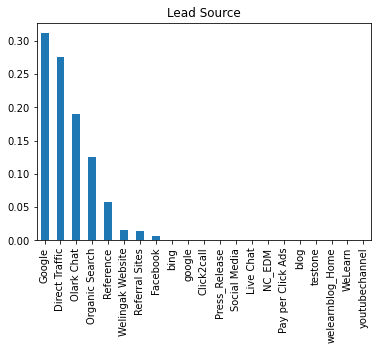

In [18]:
leads['Lead Source'].value_counts(normalize=True).plot.bar()
plt.title("Lead Source")
plt.show()

In [19]:
leads.Specialization.unique()

array(['Select', 'Business Administration', 'Media and Advertising', nan,
       'Supply Chain Management', 'IT Projects Management',
       'Finance Management', 'Travel and Tourism',
       'Human Resource Management', 'Marketing Management',
       'Banking, Investment And Insurance', 'International Business',
       'E-COMMERCE', 'Operations Management', 'Retail Management',
       'Services Excellence', 'Hospitality Management',
       'Rural and Agribusiness', 'Healthcare Management', 'E-Business'],
      dtype=object)

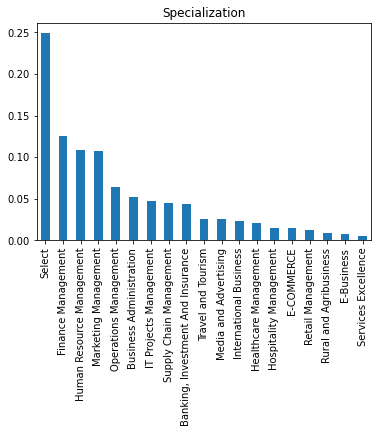

In [20]:
leads.Specialization.value_counts(normalize=True).plot.bar()
plt.title("Specialization")
plt.show()

In [21]:
leads.Country.unique()

array([nan, 'India', 'Russia', 'Kuwait', 'Oman', 'United Arab Emirates',
       'United States', 'Australia', 'United Kingdom', 'Bahrain', 'Ghana',
       'Singapore', 'Qatar', 'Saudi Arabia', 'Belgium', 'France',
       'Sri Lanka', 'China', 'Canada', 'Netherlands', 'Sweden', 'Nigeria',
       'Hong Kong', 'Germany', 'Asia/Pacific Region', 'Uganda', 'Kenya',
       'Italy', 'South Africa', 'Tanzania', 'unknown', 'Malaysia',
       'Liberia', 'Switzerland', 'Denmark', 'Philippines', 'Bangladesh',
       'Vietnam', 'Indonesia'], dtype=object)

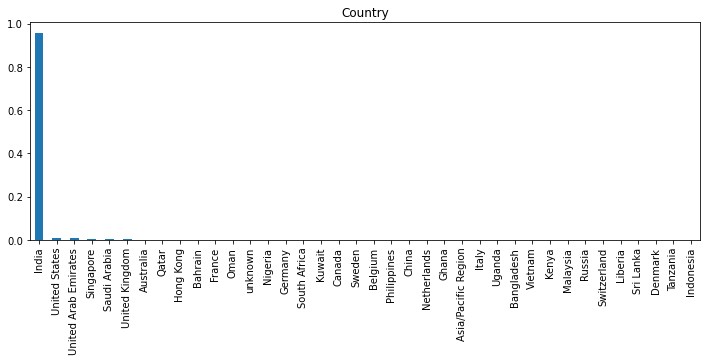

In [22]:
plt.figure(figsize=[12, 4])
leads.Country.value_counts(normalize=True).plot.bar()
plt.title("Country")
plt.show()

In [23]:
leads['hear_from'].unique()

array(['Select', 'Word Of Mouth', 'Other', nan, 'Online Search',
       'Multiple Sources', 'Advertisements', 'Student of SomeSchool',
       'Email', 'Social Media', 'SMS'], dtype=object)

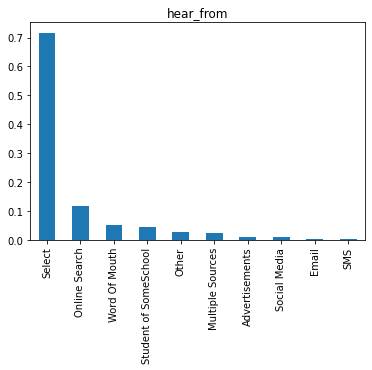

In [24]:
leads['hear_from'].value_counts(normalize=True).plot.bar()
plt.title("hear_from")
plt.show()

In [25]:
leads['Occupation'].unique()

array(['Unemployed', 'Student', nan, 'Working Professional',
       'Businessman', 'Other', 'Housewife'], dtype=object)

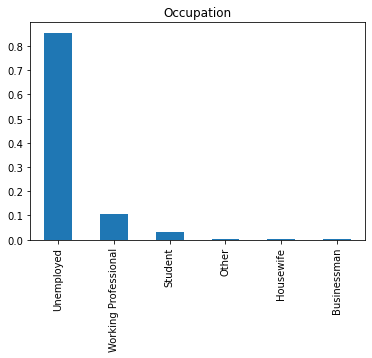

In [26]:
leads['Occupation'].value_counts(normalize=True).plot.bar()
plt.title("Occupation")
plt.show()

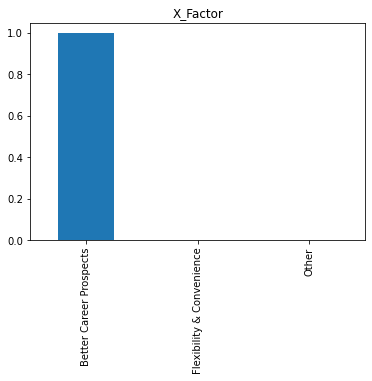

In [27]:
leads['X_Factor'].value_counts(normalize=True).plot.bar()
plt.title("X_Factor")
plt.show()

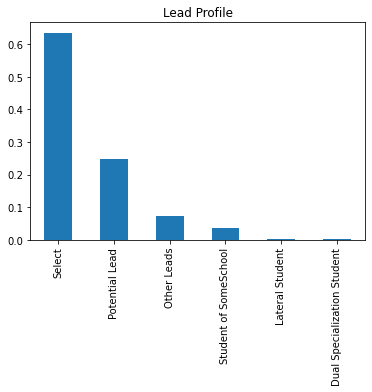

In [28]:
leads['Lead Profile'].value_counts(normalize=True).plot.bar()
plt.title("Lead Profile")
plt.show()

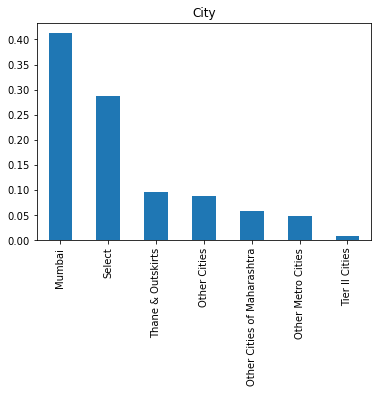

In [29]:
leads.City.value_counts(normalize=True).plot.bar()
plt.title("City")
plt.show()

In [30]:
leads['Last Notable Activity'].unique()

array(['Modified', 'Email Opened', 'Page Visited on Website',
       'Email Bounced', 'Email Link Clicked', 'Unreachable',
       'Unsubscribed', 'Had a Phone Conversation',
       'Olark Chat Conversation', 'SMS Sent', 'Approached upfront',
       'Resubscribed to emails', 'View in browser link Clicked',
       'Form Submitted on Website', 'Email Received', 'Email Marked Spam'],
      dtype=object)

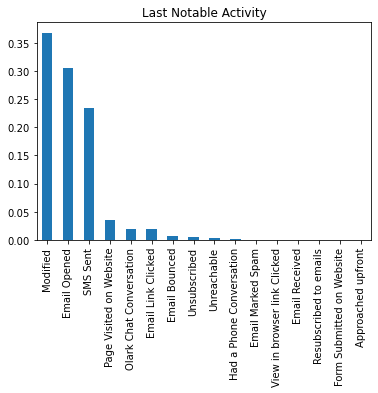

In [31]:
leads['Last Notable Activity'].value_counts(normalize=True).plot.bar()
plt.title("Last Notable Activity")
plt.show()

### Impute values

In [32]:
#impute Select with None
leads.Specialization = leads.Specialization.replace(to_replace = 'Select', value = np.nan)
leads.Specialization.unique()

array([nan, 'Business Administration', 'Media and Advertising',
       'Supply Chain Management', 'IT Projects Management',
       'Finance Management', 'Travel and Tourism',
       'Human Resource Management', 'Marketing Management',
       'Banking, Investment And Insurance', 'International Business',
       'E-COMMERCE', 'Operations Management', 'Retail Management',
       'Services Excellence', 'Hospitality Management',
       'Rural and Agribusiness', 'Healthcare Management', 'E-Business'],
      dtype=object)

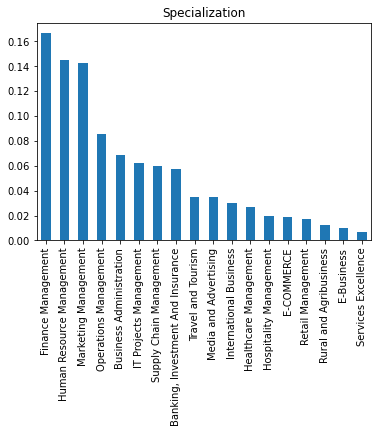

In [33]:
leads.Specialization.value_counts(normalize=True).plot.bar()
plt.title("Specialization")
plt.show()

In [34]:
leads['hear_from'] = leads['hear_from'].replace(to_replace = 'Select', value = np.nan)
leads['hear_from'].unique()

array([nan, 'Word Of Mouth', 'Other', 'Online Search', 'Multiple Sources',
       'Advertisements', 'Student of SomeSchool', 'Email', 'Social Media',
       'SMS'], dtype=object)

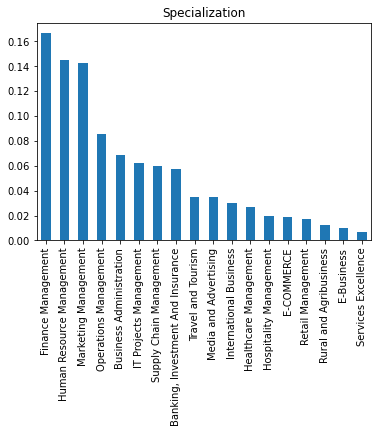

In [35]:
leads.Specialization.value_counts(normalize=True).plot.bar()
plt.title("Specialization")
plt.show()

In [36]:
leads[['Specialization', 'hear_from']].isnull().sum() * 100 / leads.shape[0]

Specialization    36.580087
hear_from         78.463203
dtype: float64

In [37]:
#dropping both the columns since the missing values are more than 30%
leads.drop(['Specialization', 'hear_from'], axis=1, inplace=True)

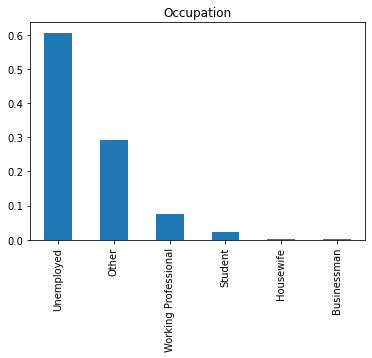

In [38]:
# we are replacing null values with Other
leads[['Occupation']] = leads[['Occupation']].fillna(value='Other')
leads['Occupation'].value_counts(normalize=True).plot.bar()
plt.title("Occupation")
plt.show()

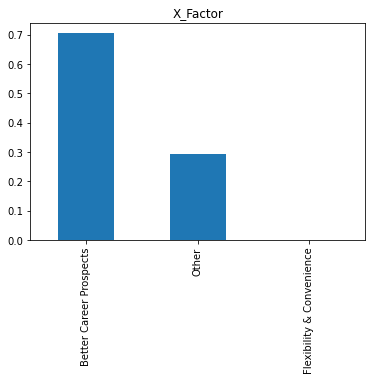

In [39]:
# we are replacing null values with Other
leads['X_Factor'] = leads[['X_Factor']].fillna(value='Other')
leads['X_Factor'].value_counts(normalize=True).plot.bar()
plt.title("X_Factor")
plt.show()

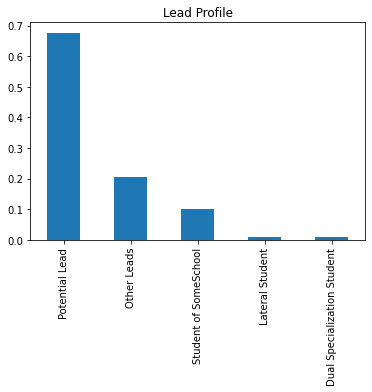

In [40]:
leads['Lead Profile'] = leads['Lead Profile'].replace(to_replace='Select', value = np.nan)
leads['Lead Profile'].value_counts(normalize=True).plot.bar()
plt.title("Lead Profile")
plt.show()

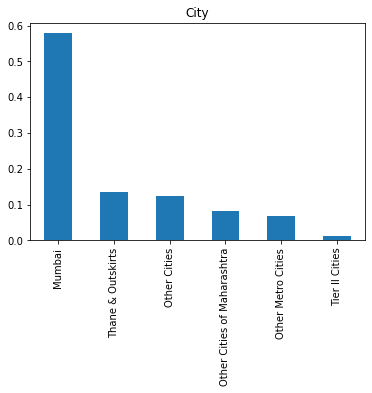

In [41]:
leads.City = leads.City.replace(to_replace='Select', value = np.nan)
leads.City.value_counts(normalize=True).plot.bar()
plt.title("City")
plt.show()

In [42]:
leads[['Lead Profile','City']].isnull().sum() * 100 / leads.shape[0]

Lead Profile    74.188312
City            39.707792
dtype: float64

In [43]:
#dropping both the columns since the missing values are more than 30%
leads.drop(['Lead Profile','City'], axis=1, inplace=True)

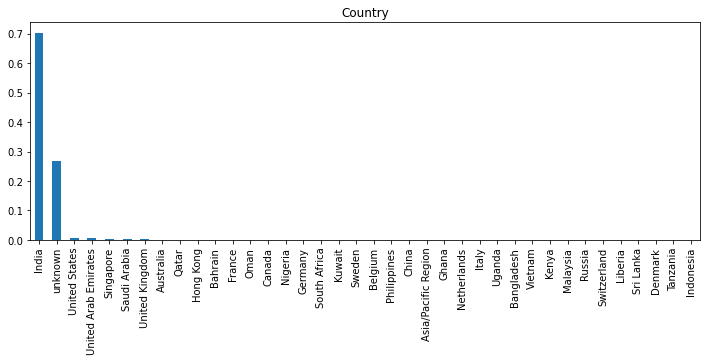

In [44]:
plt.figure(figsize=[12, 4])
leads.Country = leads.Country.fillna(value='unknown')
leads.Country.value_counts(normalize=True).plot.bar()
plt.title("Country")
plt.show()

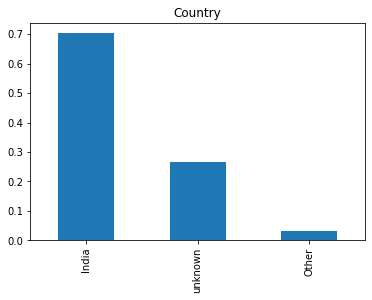

In [45]:
#create Other_countries category
list_of_countries = leads.Country.value_counts()[(leads.Country.value_counts()).sort_values(ascending=False) < 100].keys().to_list()
leads.Country = leads.Country.replace(to_replace=list_of_countries, value = 'Other')
leads.Country.value_counts(normalize=True).plot.bar()
plt.title("Country")
plt.show()

Replace No:0 and Yes:1

In [46]:
def ans_map(x):
    return x.map({'No': 0, 'Yes': 1})

bool_cols = ['Do Not Email','Do Not Call', 'Search', 'Newspaper Article', 
    'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations',
    'copy_msting_interview']
leads[bool_cols] = leads[bool_cols].apply(ans_map)
leads[bool_cols] = leads[bool_cols].astype('int8')
leads.head()

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,total_time_spent,views_per_visit,Country,Occupation,X_Factor,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,copy_msting_interview,Last Notable Activity
0,API,Olark Chat,0,0,0,0.0,0,0.0,unknown,Unemployed,Better Career Prospects,0,0,0,0,0,0,0,Modified
1,API,Organic Search,0,0,0,5.0,674,2.5,India,Unemployed,Better Career Prospects,0,0,0,0,0,0,0,Email Opened
2,Landing Page Submission,Direct Traffic,0,0,1,2.0,1532,2.0,India,Student,Better Career Prospects,0,0,0,0,0,0,1,Email Opened
3,Landing Page Submission,Direct Traffic,0,0,0,1.0,305,1.0,India,Unemployed,Better Career Prospects,0,0,0,0,0,0,0,Modified
4,Landing Page Submission,Google,0,0,1,2.0,1428,1.0,India,Unemployed,Better Career Prospects,0,0,0,0,0,0,0,Modified


In [47]:
leads.shape

(9240, 19)

In [48]:
leads[bool_cols].describe()

,Do Not Email,Do Not Call,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,copy_msting_interview
count,9240.000000,9240.000000,9240.000000,9240.000000,9240.000000,9240.000000,9240.000000,9240.000000,9240.000000
mean,0.079437,0.000216,0.001515,0.000216,0.000108,0.000108,0.000433,0.000758,0.312554
std,0.270435,0.014711,0.038898,0.014711,0.010403,0.010403,0.020803,0.027515,0.463559
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [49]:
percent_missing_info = (leads.isnull().sum() * 100 / leads.shape[0]).sort_values(ascending=False)
percent_missing_info[:7]

TotalVisits              1.482684
views_per_visit          1.482684
Lead Source              0.389610
Last Notable Activity    0.000000
Country                  0.000000
Do Not Email             0.000000
Do Not Call              0.000000
dtype: float64

In [50]:
leads[['TotalVisits', 'views_per_visit']].describe()

,TotalVisits,views_per_visit
count,9103.000000,9103.000000
mean,3.445238,2.362820
std,4.854853,2.161418
min,0.000000,0.000000
25%,1.000000,1.000000
50%,3.000000,2.000000
75%,5.000000,3.000000
max,251.000000,55.000000


In [51]:
#replace ['TotalVisits', 'views_per_visit'] with medians
leads.TotalVisits = leads.TotalVisits.fillna(value=leads.TotalVisits.median())
leads[['views_per_visit']] = leads[['views_per_visit']].fillna(value=leads['views_per_visit'].median())

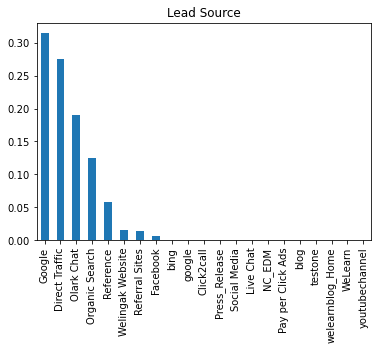

In [52]:
leads[['Lead Source']] = leads[['Lead Source']].fillna(value=leads['Lead Source'].mode()[0])
leads['Lead Source'].value_counts(normalize=True).plot.bar()
plt.title("Lead Source")
plt.show()

In [53]:
(leads['Lead Source'].value_counts()).sort_values(ascending=False)

Google               2904
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
google                  5
Click2call              4
Press_Release           2
Social Media            2
Live Chat               2
WeLearn                 1
NC_EDM                  1
Pay per Click Ads       1
blog                    1
testone                 1
welearnblog_Home        1
youtubechannel          1
Name: Lead Source, dtype: int64

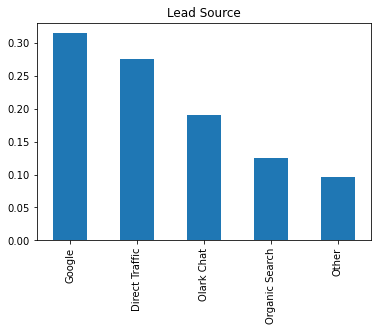

In [54]:
#create a new category for Lead Source
list_of_lead_source = leads['Lead Source'].value_counts()[(leads['Lead Source'].value_counts()).sort_values(ascending=False) < 1100].keys().to_list()
leads['Lead Source'] = leads['Lead Source'].replace(to_replace=list_of_lead_source, value = 'Other')
leads['Lead Source'].value_counts(normalize=True).plot.bar()
plt.title("Lead Source")
plt.show()

In [55]:
(leads['Last Notable Activity'].value_counts()).sort_values(ascending=False)

Modified                        3407
Email Opened                    2827
SMS Sent                        2172
Page Visited on Website          318
Olark Chat Conversation          183
Email Link Clicked               173
Email Bounced                     60
Unsubscribed                      47
Unreachable                       32
Had a Phone Conversation          14
Email Marked Spam                  2
Approached upfront                 1
Form Submitted on Website          1
Resubscribed to emails             1
Email Received                     1
View in browser link Clicked       1
Name: Last Notable Activity, dtype: int64

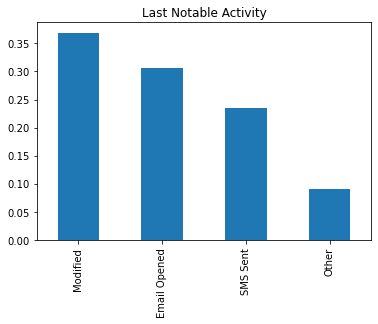

In [56]:
list_of_notable_activities = leads['Last Notable Activity'].value_counts()[(leads['Last Notable Activity'].value_counts()).sort_values(ascending=False) < 350].keys().to_list()
leads['Last Notable Activity'] = leads['Last Notable Activity'].replace(to_replace=list_of_notable_activities, value = 'Other')
leads['Last Notable Activity'].value_counts(normalize=True).plot.bar()
plt.title("Last Notable Activity")
plt.show()

In [57]:
(leads.isnull().sum() * 100 / leads.shape[0]).sort_values(ascending=False)

Last Notable Activity      0.0
Country                    0.0
Lead Source                0.0
Do Not Email               0.0
Do Not Call                0.0
Converted                  0.0
TotalVisits                0.0
total_time_spent           0.0
views_per_visit            0.0
Occupation                 0.0
copy_msting_interview      0.0
X_Factor                   0.0
Search                     0.0
Newspaper Article          0.0
X Education Forums         0.0
Newspaper                  0.0
Digital Advertisement      0.0
Through Recommendations    0.0
Lead Origin                0.0
dtype: float64

In [58]:
leads.head()

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,total_time_spent,views_per_visit,Country,Occupation,X_Factor,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,copy_msting_interview,Last Notable Activity
0,API,Olark Chat,0,0,0,0.0,0,0.0,unknown,Unemployed,Better Career Prospects,0,0,0,0,0,0,0,Modified
1,API,Organic Search,0,0,0,5.0,674,2.5,India,Unemployed,Better Career Prospects,0,0,0,0,0,0,0,Email Opened
2,Landing Page Submission,Direct Traffic,0,0,1,2.0,1532,2.0,India,Student,Better Career Prospects,0,0,0,0,0,0,1,Email Opened
3,Landing Page Submission,Direct Traffic,0,0,0,1.0,305,1.0,India,Unemployed,Better Career Prospects,0,0,0,0,0,0,0,Modified
4,Landing Page Submission,Google,0,0,1,2.0,1428,1.0,India,Unemployed,Better Career Prospects,0,0,0,0,0,0,0,Modified


In [59]:
leads[bool_cols].describe()

,Do Not Email,Do Not Call,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,copy_msting_interview
count,9240.000000,9240.000000,9240.000000,9240.000000,9240.000000,9240.000000,9240.000000,9240.000000,9240.000000
mean,0.079437,0.000216,0.001515,0.000216,0.000108,0.000108,0.000433,0.000758,0.312554
std,0.270435,0.014711,0.038898,0.014711,0.010403,0.010403,0.020803,0.027515,0.463559
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [60]:
leads.shape

(9240, 19)

#### Check the outliers from the data

<Figure size 1728x1080 with 0 Axes>

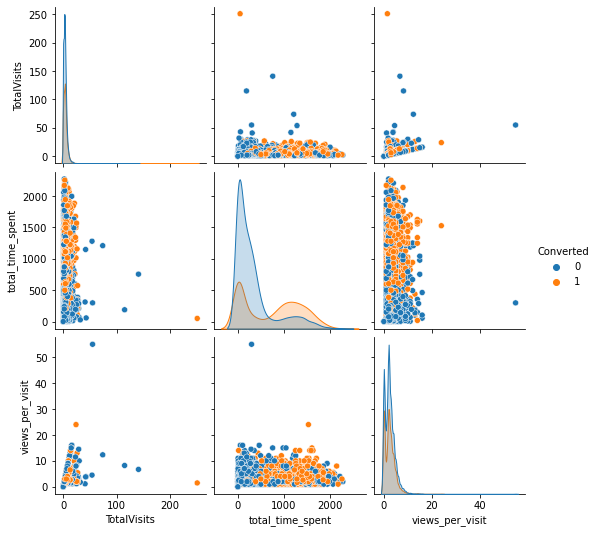

In [61]:
plt.figure(figsize = (24, 15))
cont_cols = ['TotalVisits', 'total_time_spent', 'views_per_visit']
sns.pairplot(leads[(cont_cols+['Converted'])], diag_kind='kde',hue='Converted')
plt.show()


In [62]:
leads[cont_cols].describe(percentiles=[.25, .5, .75, .90, .95, .99])

,TotalVisits,total_time_spent,views_per_visit
count,9240.000000,9240.000000,9240.000000
mean,3.438636,487.698268,2.357440
std,4.819024,548.021466,2.145781
min,0.000000,0.000000,0.000000
25%,1.000000,12.000000,1.000000
50%,3.000000,248.000000,2.000000
75%,5.000000,936.000000,3.000000
90%,7.000000,1380.000000,5.000000
95%,10.000000,1562.000000,6.000000
99%,17.000000,1840.610000,9.000000


- The data is not gradually increasing, clearly there are some outliers in the data

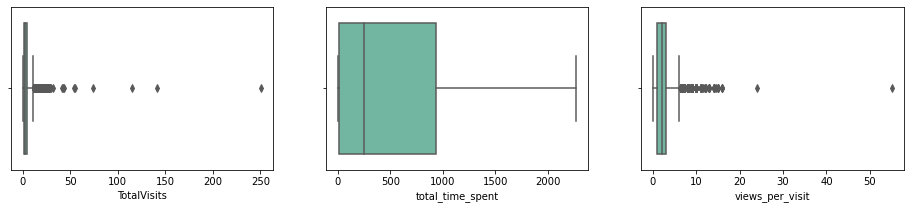

In [63]:
def show_cont_var():  
    plt.figure(figsize=(16, 3))
    r=1
    c=3
    plt.subplot(r,c,1)
    sns.boxplot(data=leads, x='TotalVisits',palette="Set2")
    plt.subplot(r,c,2)
    sns.boxplot(data=leads, x='total_time_spent',palette="Set2")
    plt.subplot(r,c,3)
    sns.boxplot(data=leads, x='views_per_visit',palette="Set2")
    plt.show()

show_cont_var()

In [64]:
leads = leads[leads.TotalVisits < leads.TotalVisits.quantile(0.97)]

In [65]:
# % of data retention
leads.shape[0]/o_shape[0]

0.9617965367965368

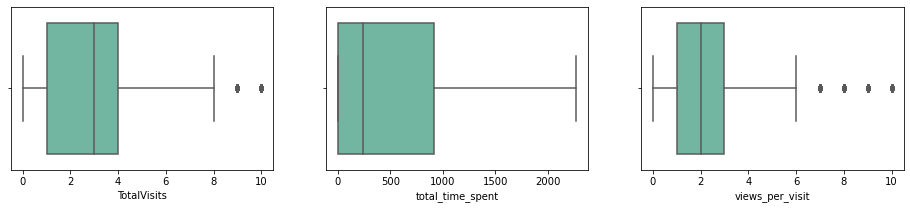

In [66]:
show_cont_var()

In [67]:
leads = leads[leads['views_per_visit'] < leads['views_per_visit'].quantile(0.97)]

In [68]:
# % of data retention
leads.shape[0]/o_shape[0]

0.9319264069264069

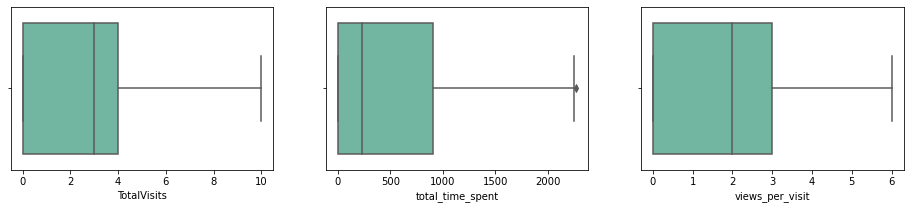

In [69]:
show_cont_var()

In [70]:
leads = leads[leads['total_time_spent'] < leads['total_time_spent'].quantile(0.97)]

In [71]:
# % of data retention
leads.shape[0]/o_shape[0]

0.9037878787878788

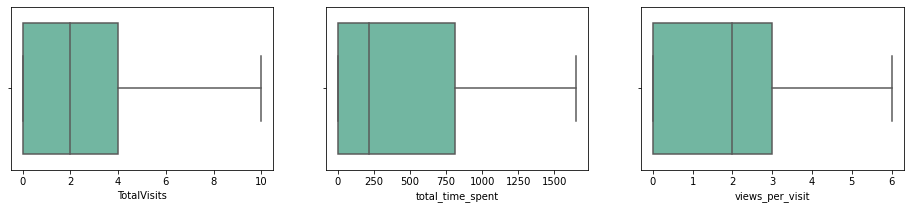

In [72]:
show_cont_var()

In [73]:
leads[bool_cols].describe()

,Do Not Email,Do Not Call,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,copy_msting_interview
count,8351.000000,8351.000000,8351.000000,8351.0,8351.0,8351.0,8351.000000,8351.000000,8351.000000
mean,0.077715,0.000239,0.000718,0.0,0.0,0.0,0.000239,0.000359,0.292181
std,0.267739,0.015475,0.026796,0.0,0.0,0.0,0.015475,0.018951,0.454792
min,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000


- after removing outliers, it seems that 
the column Newspaper Article, X Education Forums, Newspaper doesnt have any different value
- hence we are removing these columns

In [74]:
leads.drop(['Newspaper Article','X Education Forums','Newspaper'], axis=1, inplace=True)

In [75]:
leads.head()

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,total_time_spent,views_per_visit,Country,Occupation,X_Factor,Search,Digital Advertisement,Through Recommendations,copy_msting_interview,Last Notable Activity
0,API,Olark Chat,0,0,0,0.0,0,0.0,unknown,Unemployed,Better Career Prospects,0,0,0,0,Modified
1,API,Organic Search,0,0,0,5.0,674,2.5,India,Unemployed,Better Career Prospects,0,0,0,0,Email Opened
2,Landing Page Submission,Direct Traffic,0,0,1,2.0,1532,2.0,India,Student,Better Career Prospects,0,0,0,1,Email Opened
3,Landing Page Submission,Direct Traffic,0,0,0,1.0,305,1.0,India,Unemployed,Better Career Prospects,0,0,0,0,Modified
4,Landing Page Submission,Google,0,0,1,2.0,1428,1.0,India,Unemployed,Better Career Prospects,0,0,0,0,Modified


In [76]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8351 entries, 0 to 9239
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Lead Origin              8351 non-null   object 
 1   Lead Source              8351 non-null   object 
 2   Do Not Email             8351 non-null   int8   
 3   Do Not Call              8351 non-null   int8   
 4   Converted                8351 non-null   int64  
 5   TotalVisits              8351 non-null   float64
 6   total_time_spent         8351 non-null   int64  
 7   views_per_visit          8351 non-null   float64
 8   Country                  8351 non-null   object 
 9   Occupation               8351 non-null   object 
 10  X_Factor                 8351 non-null   object 
 11  Search                   8351 non-null   int8   
 12  Digital Advertisement    8351 non-null   int8   
 13  Through Recommendations  8351 non-null   int8   
 14  copy_msting_interview   

In [77]:
leads.shape

(8351, 16)

### Data Visualization

<Figure size 1728x1080 with 0 Axes>

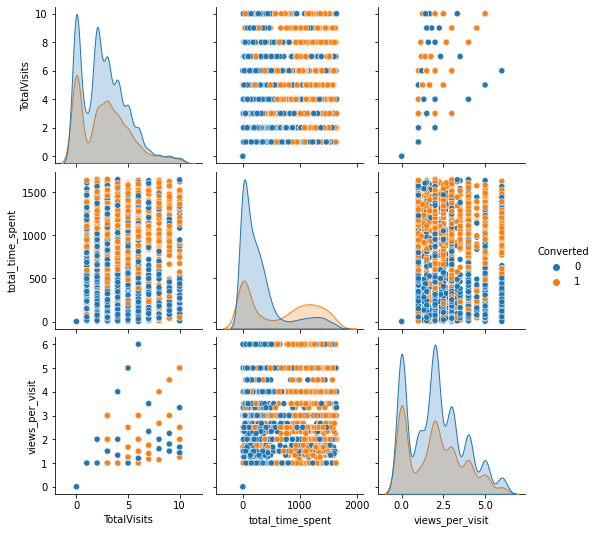

In [78]:
plt.figure(figsize = (24, 15))
sns.pairplot(leads[cont_cols + ['Converted']], diag_kind='kde',hue='Converted')
plt.show()


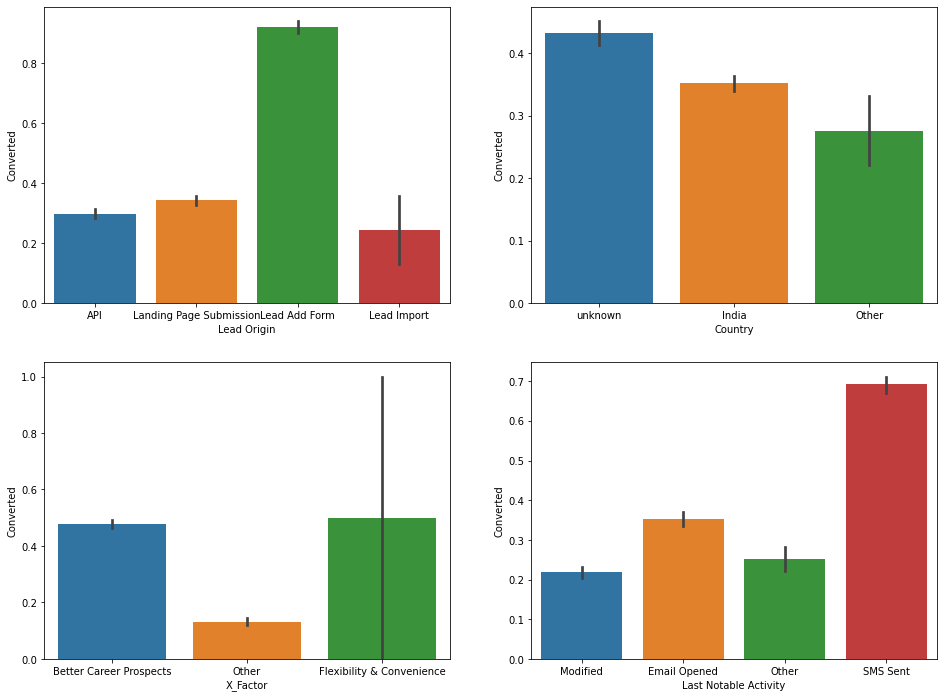

In [79]:
plt.figure(figsize=(16, 12))
r = 2
c = 2
plt.subplot(r,c,1)
sns.barplot(x = 'Lead Origin', y = 'Converted', data = leads)
plt.subplot(r,c,2)
sns.barplot(x = 'Country', y = 'Converted', data = leads)
plt.subplot(r,c,3)
sns.barplot(x = 'X_Factor', y = 'Converted', data = leads)
plt.subplot(r,c,4)
sns.barplot(x = 'Last Notable Activity', y = 'Converted', data = leads)
plt.show()

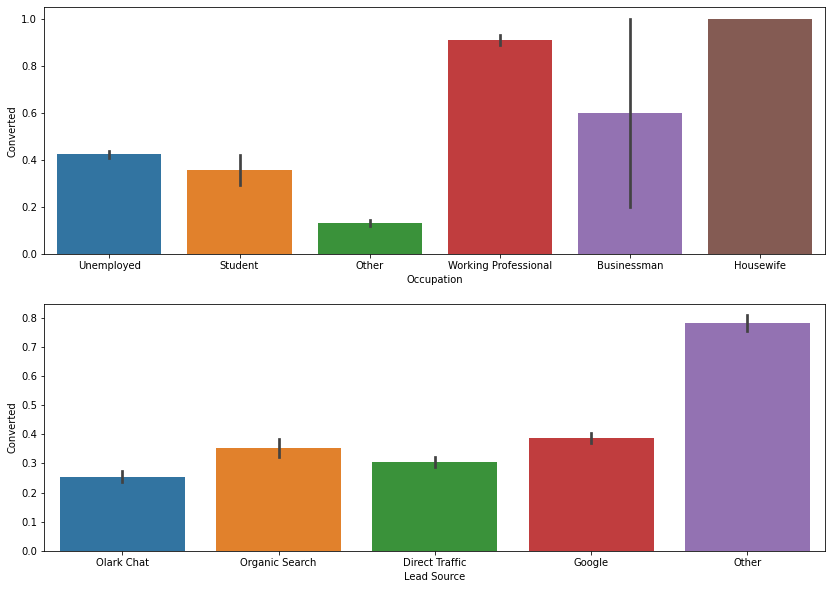

In [80]:
plt.figure(figsize=(14, 10))
r = 2
c = 1
plt.subplot(r,c,1)
sns.barplot(x = 'Occupation', y = 'Converted', data = leads)
plt.subplot(r,c,2)
sns.barplot(x = 'Lead Source', y = 'Converted', data = leads)
plt.show()

### Dummy Variables

In [81]:
lead_origin = pd.get_dummies(leads['Lead Origin'], drop_first = True, prefix = 'Lead_Origin')
occupation = pd.get_dummies(leads['Occupation'], drop_first = True, prefix = 'Occupation')
lead_source = pd.get_dummies(leads['Lead Source'], drop_first = True, prefix = 'Lead_Source')
country = pd.get_dummies(leads['Country'], drop_first = True, prefix = 'Country')
x_Factor = pd.get_dummies(leads['X_Factor'], drop_first = True, prefix = 'X_Factor')
last_notable_ctivity = pd.get_dummies(leads['Last Notable Activity'], drop_first = True, prefix = 'Last_Notable_Activity')

In [82]:
leads = pd.concat([leads, lead_origin, occupation, lead_source, country, x_Factor, last_notable_ctivity], axis=1)

In [83]:
leads.drop(['Lead Origin', 'Occupation', 'Lead Source', 'Country', 'X_Factor', 'Last Notable Activity'],
           axis = 1, inplace = True)

In [84]:
leads.head()

,Do Not Email,Do Not Call,Converted,TotalVisits,total_time_spent,views_per_visit,Search,Digital Advertisement,Through Recommendations,copy_msting_interview,Lead_Origin_Landing Page Submission,Lead_Origin_Lead Add Form,Lead_Origin_Lead Import,Occupation_Housewife,Occupation_Other,Occupation_Student,Occupation_Unemployed,Occupation_Working Professional,Lead_Source_Google,Lead_Source_Olark Chat,Lead_Source_Organic Search,Lead_Source_Other,Country_Other,Country_unknown,X_Factor_Flexibility & Convenience,X_Factor_Other,Last_Notable_Activity_Modified,Last_Notable_Activity_Other,Last_Notable_Activity_SMS Sent
0,0,0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0
1,0,0,0,5.0,674,2.5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,1,2.0,1532,2.0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1.0,305,1.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,1,2.0,1428,1.0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [85]:
leads.describe()

,Do Not Email,Do Not Call,Converted,TotalVisits,total_time_spent,views_per_visit,Search,Digital Advertisement,Through Recommendations,copy_msting_interview,Lead_Origin_Landing Page Submission,Lead_Origin_Lead Add Form,Lead_Origin_Lead Import,Occupation_Housewife,Occupation_Other,Occupation_Student,Occupation_Unemployed,Occupation_Working Professional,Lead_Source_Google,Lead_Source_Olark Chat,Lead_Source_Organic Search,Lead_Source_Other,Country_Other,Country_unknown,X_Factor_Flexibility & Convenience,X_Factor_Other,Last_Notable_Activity_Modified,Last_Notable_Activity_Other,Last_Notable_Activity_SMS Sent
count,8351.000000,8351.000000,8351.000000,8351.000000,8351.000000,8351.000000,8351.000000,8351.000000,8351.000000,8351.000000,8351.000000,8351.000000,8351.000000,8351.000000,8351.000000,8351.000000,8351.000000,8351.000000,8351.000000,8351.000000,8351.000000,8351.000000,8351.000000,8351.000000,8351.000000,8351.000000,8351.000000,8351.000000,8351.000000
mean,0.077715,0.000239,0.372530,2.716321,432.575021,2.038234,0.000718,0.000239,0.000359,0.292181,0.506406,0.083224,0.006347,0.001197,0.300922,0.023829,0.598371,0.075081,0.316489,0.208119,0.106694,0.099629,0.030416,0.291103,0.000239,0.301641,0.379116,0.083822,0.233505
std,0.267739,0.015475,0.483507,2.317467,498.744623,1.639528,0.026796,0.015475,0.018951,0.454792,0.499989,0.276236,0.079417,0.034586,0.458686,0.152527,0.490257,0.263538,0.465134,0.405987,0.308742,0.299522,0.171738,0.454298,0.015475,0.458998,0.485196,0.277138,0.423086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,2.000000,219.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,4.000000,809.500000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,10.000000,1652.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [86]:
leads.shape

(8351, 29)

### Test-Train Split for Model

In [87]:
X = leads.drop(['Converted'], axis=1)

X.head()

,Do Not Email,Do Not Call,TotalVisits,total_time_spent,views_per_visit,Search,Digital Advertisement,Through Recommendations,copy_msting_interview,Lead_Origin_Landing Page Submission,Lead_Origin_Lead Add Form,Lead_Origin_Lead Import,Occupation_Housewife,Occupation_Other,Occupation_Student,Occupation_Unemployed,Occupation_Working Professional,Lead_Source_Google,Lead_Source_Olark Chat,Lead_Source_Organic Search,Lead_Source_Other,Country_Other,Country_unknown,X_Factor_Flexibility & Convenience,X_Factor_Other,Last_Notable_Activity_Modified,Last_Notable_Activity_Other,Last_Notable_Activity_SMS Sent
0,0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0
1,0,0,5.0,674,2.5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,2.0,1532,2.0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1.0,305,1.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,2.0,1428,1.0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [88]:
y = leads['Converted']

y.head()

0    0
1    0
2    1
3    0
4    1
Name: Converted, dtype: int64

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [90]:
scaler = MinMaxScaler()
X_train[cont_cols] = scaler.fit_transform(X_train[cont_cols])
X_train[cont_cols].describe()

,TotalVisits,total_time_spent,views_per_visit
count,5845.000000,5845.000000,5845.000000
mean,0.272027,0.268508,0.340785
std,0.230642,0.304922,0.272354
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.200000,0.138620,0.333333
75%,0.400000,0.512712,0.500000
max,1.000000,1.000000,1.000000


In [91]:
converted = (sum(leads['Converted'])/len(leads['Converted'].index)) * 100
converted

37.25302358998922

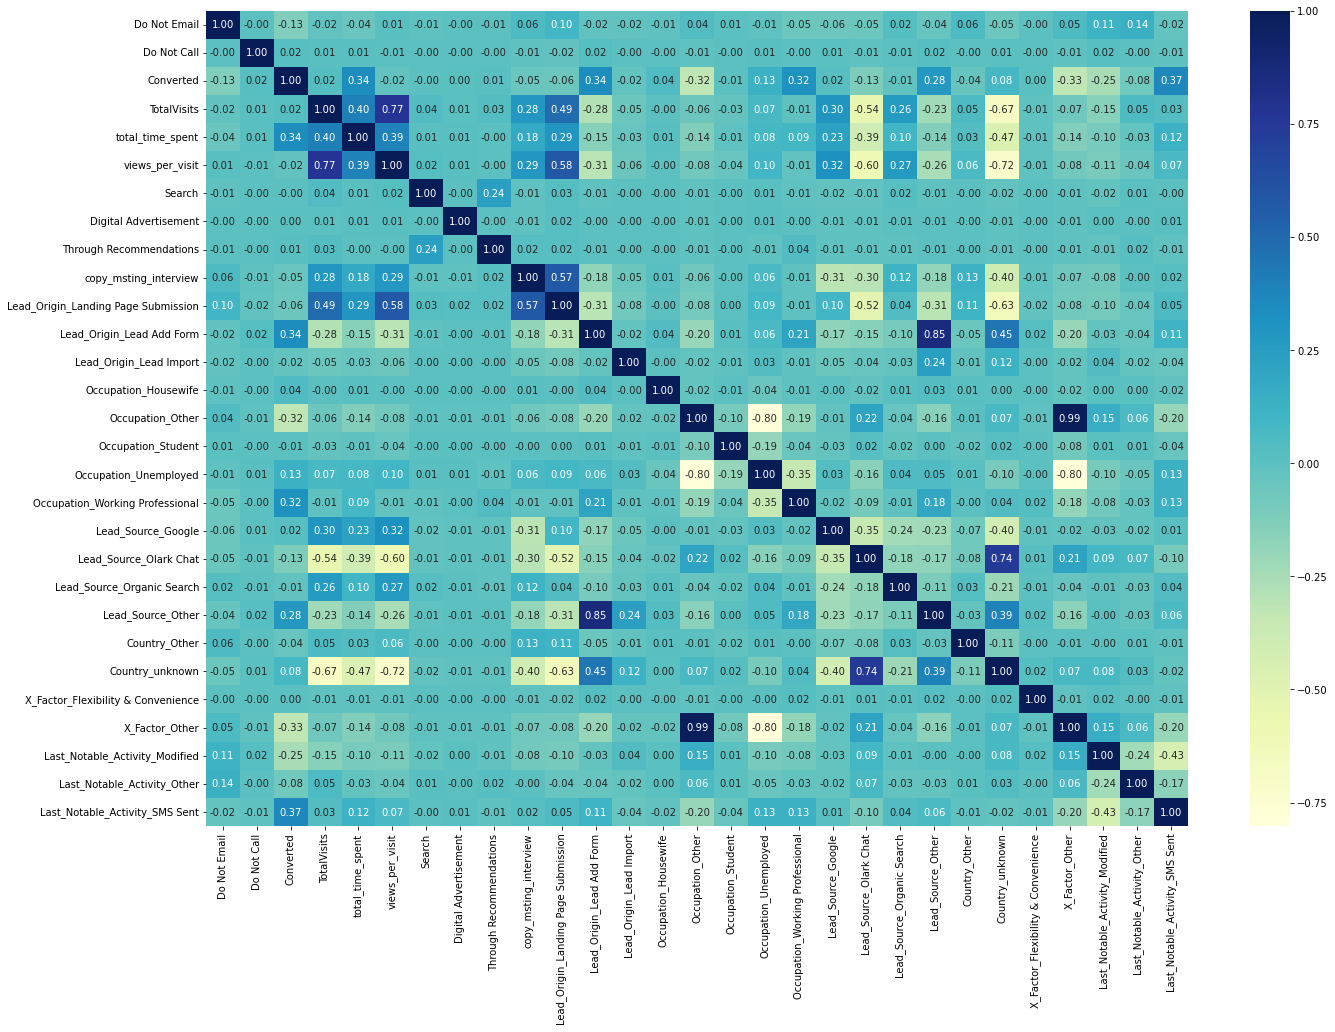

In [92]:
plt.figure(figsize = (22, 15))
sns.heatmap(leads.corr(),annot = True, cmap="YlGnBu", fmt=".2f")
plt.show()

### Model Building

In [93]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
res = logm1.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 5845
Model:                            GLM   Df Residuals:                     5816
Model Family:                Binomial   Df Model:                           28
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2373.2
Date:                Tue, 12 Apr 2022   Deviance:                       4746.3
Time:                        02:45:35   Pearson chi2:                 6.30e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.4020
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

In [94]:
logreg = LogisticRegression()

In [95]:
rfe = RFE(logreg, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)

In [96]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Do Not Email', True, 1),
 ('Do Not Call', False, 4),
 ('TotalVisits', True, 1),
 ('total_time_spent', True, 1),
 ('views_per_visit', True, 1),
 ('Search', True, 1),
 ('Digital Advertisement', False, 5),
 ('Through Recommendations', False, 14),
 ('copy_msting_interview', False, 13),
 ('Lead_Origin_Landing Page Submission', False, 12),
 ('Lead_Origin_Lead Add Form', True, 1),
 ('Lead_Origin_Lead Import', False, 9),
 ('Occupation_Housewife', True, 1),
 ('Occupation_Other', True, 1),
 ('Occupation_Student', True, 1),
 ('Occupation_Unemployed', True, 1),
 ('Occupation_Working Professional', True, 1),
 ('Lead_Source_Google', False, 7),
 ('Lead_Source_Olark Chat', False, 3),
 ('Lead_Source_Organic Search', False, 11),
 ('Lead_Source_Other', False, 6),
 ('Country_Other', False, 8),
 ('Country_unknown', True, 1),
 ('X_Factor_Flexibility & Convenience', True, 1),
 ('X_Factor_Other', True, 1),
 ('Last_Notable_Activity_Modified', False, 2),
 ('Last_Notable_Activity_Other', False, 10),
 ('Last_N

In [97]:
col = X_train.columns[rfe.support_]
X_train = X_train[col]

In [98]:
X_train_sm = sm.add_constant(X_train)
logm2 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 5845
Model:                            GLM   Df Residuals:                     5829
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2403.7
Date:                Tue, 12 Apr 2022   Deviance:                       4807.5
Time:                        02:45:35   Pearson chi2:                 6.39e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.3957
Covariance Type:            nonrobust                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [99]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
7,Occupation_Other,101.95
13,X_Factor_Other,98.68
3,views_per_visit,7.84
1,TotalVisits,6.53
9,Occupation_Unemployed,6.36
11,Country_unknown,3.81
2,total_time_spent,2.41
10,Occupation_Working Professional,1.87
5,Lead_Origin_Lead Add Form,1.53
14,Last_Notable_Activity_SMS Sent,1.42


In [100]:
X_train.drop('X_Factor_Flexibility & Convenience', axis = 1, inplace = True)

In [101]:
logm3 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
res = logm3.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 5845
Model:                            GLM   Df Residuals:                     5830
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2408.4
Date:                Tue, 12 Apr 2022   Deviance:                       4816.8
Time:                        02:45:36   Pearson chi2:                 6.42e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.3948
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [102]:
X_train.drop('Search', axis = 1, inplace = True)

In [103]:
logm4 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
res = logm4.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 5845
Model:                            GLM   Df Residuals:                     5831
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2409.6
Date:                Tue, 12 Apr 2022   Deviance:                       4819.2
Time:                        02:45:36   Pearson chi2:                 6.42e+03
No. Iterations:                    20   Pseudo R-squ. (CS):             0.3945
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [104]:
X_train.drop('Occupation_Housewife', axis = 1, inplace = True)

In [105]:
logm5 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
res = logm5.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 5845
Model:                            GLM   Df Residuals:                     5832
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2410.1
Date:                Tue, 12 Apr 2022   Deviance:                       4820.2
Time:                        02:45:36   Pearson chi2:                 6.42e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3944
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [106]:
X_train.drop('Occupation_Working Professional', axis = 1, inplace = True)

In [107]:
logm6 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
res = logm6.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 5845
Model:                            GLM   Df Residuals:                     5833
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2410.1
Date:                Tue, 12 Apr 2022   Deviance:                       4820.2
Time:                        02:45:36   Pearson chi2:                 6.42e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3944
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [108]:
X_train.drop('Occupation_Other', axis = 1, inplace = True)

In [109]:
logm7 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
res = logm7.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 5845
Model:                            GLM   Df Residuals:                     5834
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2411.8
Date:                Tue, 12 Apr 2022   Deviance:                       4823.6
Time:                        02:45:36   Pearson chi2:                 6.40e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3941
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [110]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,views_per_visit,7.22
1,TotalVisits,6.28
6,Occupation_Unemployed,3.97
7,Country_unknown,2.87
8,X_Factor_Other,2.52
2,total_time_spent,2.19
4,Lead_Origin_Lead Add Form,1.50
9,Last_Notable_Activity_SMS Sent,1.38
0,Do Not Email,1.10
5,Occupation_Student,1.10


In [111]:
X_train.drop('views_per_visit', axis = 1, inplace = True)

In [112]:
logm8 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
res = logm8.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 5845
Model:                            GLM   Df Residuals:                     5835
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2422.2
Date:                Tue, 12 Apr 2022   Deviance:                       4844.3
Time:                        02:45:36   Pearson chi2:                 6.48e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3919
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [113]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,TotalVisits,3.52
5,Occupation_Unemployed,3.47
6,Country_unknown,2.65
7,X_Factor_Other,2.28
2,total_time_spent,2.17
3,Lead_Origin_Lead Add Form,1.50
8,Last_Notable_Activity_SMS Sent,1.36
0,Do Not Email,1.10
4,Occupation_Student,1.09


### Model Evaluation

In [114]:
y_train_pred = res.predict(sm.add_constant(X_train))
y_train_pred[:5]

901     0.692386
7123    0.035575
5911    0.900289
8999    0.233334
9212    0.038782
dtype: float64

In [115]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.69238563, 0.03557459, 0.90028928, 0.23333443, 0.03878209,
       0.04397131, 0.1317681 , 0.32728873, 0.02959077, 0.08621808])

#### Creating a dataframe with the actual conversion flag and the predicted probabilities

In [116]:
#Create a new dataframe containing the actual conversion flag and the probabilities predicted by the model
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Conversion_Prob':y_train_pred})
y_train_pred_final.head()

,Converted,Conversion_Prob
0,1,0.692386
1,0,0.035575
2,1,0.900289
3,1,0.233334
4,0,0.038782


In [117]:
y_train_pred_final['Predicted'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Converted,Conversion_Prob,Predicted
0,1,0.692386,1
1,0,0.035575,0
2,1,0.900289,1
3,1,0.233334,0
4,0,0.038782,0


In [118]:
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted )
confusion

array([[3215,  420],
       [ 680, 1530]])

In [119]:
print(accuracy_score(y_train_pred_final.Converted, y_train_pred_final.Predicted))

0.8118049615055604


In [120]:
TP = confusion[1,1] # true + 
TN = confusion[0,0] # true -
FP = confusion[0,1] # false +
FN = confusion[1,0] # false -

In [121]:
# sensitivity
TP/(TP+FN)

0.6923076923076923

In [122]:
# specificity
TN/(TN+FP)

0.8844566712517193

In [123]:
# False + rate - predicting conversion when customer has not converted
FP/ (TN+FP)

0.1155433287482806

In [124]:
# + predictive value 
TP / (TP+FP)

0.7846153846153846

In [125]:
# - predictive value
TN / (TN+ FN)

0.8254172015404364

### Finding Optimal cutout

In [126]:
#ROC function
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs,drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False + Rate')
    plt.ylabel('True + Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [127]:
fpr, tpr, thresholds = roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob, drop_intermediate = False )

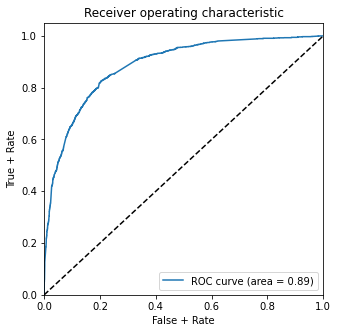

In [128]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)

- The area under the curve of the ROC is 0.89 which is quite good, we seem to have a good model

#### Check the sensitivity and specificity tradeoff to find the optimal cutoff point

In [129]:
# Creating different probability cutoffs 
num = [float(x)/10 for x in range(10)]
for i in num:
    y_train_pred_final[i] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Conversion_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.692386,1,1,1,1,1,1,1,1,0,0,0
1,0,0.035575,0,1,0,0,0,0,0,0,0,0,0
2,1,0.900289,1,1,1,1,1,1,1,1,1,1,1
3,1,0.233334,0,1,1,1,0,0,0,0,0,0,0
4,0,0.038782,0,1,0,0,0,0,0,0,0,0,0


In [130]:
# Creating a dataframe to see the values of 
# sensitivity, accuracy and specificity at different values of probabiity cutoffs
cutoff_df = pd.DataFrame( columns = ['prob','sensitivity','accuracy','specificity'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total = sum(sum(cm))
    accuracy = (cm[0,0] + cm[1,1]) / total
    
    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
    cutoff_df.loc[i] = [ i , sensitivity, accuracy, specificity ]

cutoff_df

,prob,sensitivity,accuracy,specificity
0.0,0.0,1.000000,0.378101,0.000000
0.1,0.1,0.974208,0.627716,0.417056
0.2,0.2,0.916742,0.747134,0.644017
0.3,0.3,0.831222,0.804106,0.787620
0.4,0.4,0.765158,0.811805,0.840165
0.5,0.5,0.692308,0.811805,0.884457
0.6,0.6,0.619910,0.805133,0.917744
0.7,0.7,0.511312,0.784773,0.951032
0.8,0.8,0.431674,0.766638,0.970289
0.9,0.9,0.270588,0.716339,0.987345


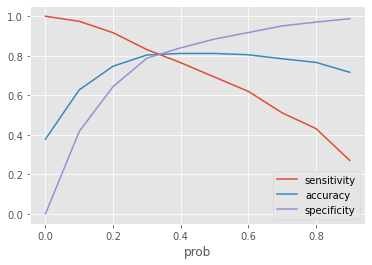

In [131]:
# Ploting the above
plt.style.use("ggplot")
cutoff_df.plot.line(x='prob', y=['sensitivity','accuracy','specificity'])
plt.show()

#### We can see  the optimal values of the three metrics at around 0.34. Lets consider 0.34 as our cutoff now.

In [132]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conversion_Prob.map( lambda x: 1 if x > 0.34 else 0)

y_train_pred_final.head()

,Converted,Conversion_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,1,0.692386,1,1,1,1,1,1,1,1,0,0,0,1
1,0,0.035575,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0.900289,1,1,1,1,1,1,1,1,1,1,1,1
3,1,0.233334,0,1,1,1,0,0,0,0,0,0,0,0
4,0,0.038782,0,1,0,0,0,0,0,0,0,0,0,0


In [133]:
#Current accuracy
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.8042771599657828

In [134]:
# Current confusion matrix
confusion2 = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion2

array([[2937,  698],
       [ 446, 1764]])

In [135]:
TP = confusion2[1,1] # true + 
TN = confusion2[0,0] # true -
FP = confusion2[0,1] # false +
FN = confusion2[1,0] # false -

In [136]:
# Sensitivity
TP/(TP+FN)

0.7981900452488688

In [137]:
# Specificity
TN/(TN+FP)

0.8079779917469051

In [138]:
# Current False + rate - predicting conversion when customer has not converted
FP/ (TN+FP)

0.1920220082530949

In [139]:
# + predictive value 
TP / (TP+FP)

0.7164906580016247

In [140]:
# - predictive value
TN / (TN+ FN)

0.8681643511676027

### Predictions on Test Dataset

In [141]:
#Scale the test set using 'transform'
X_test[cont_cols] = scaler.transform(X_test[cont_cols])

In [142]:
X_test = X_test[col]
X_test.head()

,Do Not Email,TotalVisits,total_time_spent,views_per_visit,Search,Lead_Origin_Lead Add Form,Occupation_Housewife,Occupation_Other,Occupation_Student,Occupation_Unemployed,Occupation_Working Professional,Country_unknown,X_Factor_Flexibility & Convenience,X_Factor_Other,Last_Notable_Activity_SMS Sent
4924,0,0.2,0.018160,0.333333,0,0,0,0,0,1,0,0,0,0,1
1797,0,0.4,0.217918,0.666667,0,0,0,0,0,1,0,1,0,0,0
2781,0,0.0,0.000000,0.000000,0,0,0,1,0,0,0,1,0,1,0
2294,0,0.2,0.146489,0.333333,0,0,0,0,0,1,0,0,0,0,0
3869,0,0.2,0.047821,0.333333,0,0,0,0,1,0,0,0,0,0,0


In [143]:
X_test_sm = sm.add_constant(X_test[col])
X_test_sm.head()

,const,Do Not Email,TotalVisits,total_time_spent,views_per_visit,Search,Lead_Origin_Lead Add Form,Occupation_Housewife,Occupation_Other,Occupation_Student,Occupation_Unemployed,Occupation_Working Professional,Country_unknown,X_Factor_Flexibility & Convenience,X_Factor_Other,Last_Notable_Activity_SMS Sent
4924,1.0,0,0.2,0.018160,0.333333,0,0,0,0,0,1,0,0,0,0,1
1797,1.0,0,0.4,0.217918,0.666667,0,0,0,0,0,1,0,1,0,0,0
2781,1.0,0,0.0,0.000000,0.000000,0,0,0,1,0,0,0,1,0,1,0
2294,1.0,0,0.2,0.146489,0.333333,0,0,0,0,0,1,0,0,0,0,0
3869,1.0,0,0.2,0.047821,0.333333,0,0,0,0,1,0,0,0,0,0,0


In [144]:
X_test = X_test[X_train.columns]
X_test.head()

,Do Not Email,TotalVisits,total_time_spent,Lead_Origin_Lead Add Form,Occupation_Student,Occupation_Unemployed,Country_unknown,X_Factor_Other,Last_Notable_Activity_SMS Sent
4924,0,0.2,0.018160,0,0,1,0,0,1
1797,0,0.4,0.217918,0,0,1,1,0,0
2781,0,0.0,0.000000,0,0,0,1,1,0
2294,0,0.2,0.146489,0,0,1,0,0,0
3869,0,0.2,0.047821,0,1,0,0,0,0


In [145]:
# Make predictions on the test set with the variable 'y_test_pred'
y_test_pred = res.predict(sm.add_constant(X_test))

In [146]:
y_test_pred[:5]

4924    0.335357
1797    0.479271
2781    0.086218
2294    0.131168
3869    0.100577
dtype: float64

In [147]:
y_pred_1 = pd.DataFrame(y_test_pred)
y_pred_1.head()

,0
4924,0.335357
1797,0.479271
2781,0.086218
2294,0.131168
3869,0.100577


In [148]:
# convert to dataframe
y_test_df = pd.DataFrame(y_test)

In [149]:
# resetting index
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [150]:
# Concat y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [151]:
y_pred_final.head()

,Converted,0
0,1,0.335357
1,0,0.479271
2,0,0.086218
3,0,0.131168
4,0,0.100577


In [152]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns = {0 : 'Conversion_Prob'})

In [153]:
y_pred_final.head()

,Converted,Conversion_Prob
0,1,0.335357
1,0,0.479271
2,0,0.086218
3,0,0.131168
4,0,0.100577


In [154]:
# Predicting with 0.34 threshold
y_pred_final['final_predicted'] = y_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.34 else 0)

In [155]:
y_pred_final.head()

,Converted,Conversion_Prob,final_predicted
0,1,0.335357,0
1,0,0.479271,1
2,0,0.086218,0
3,0,0.131168,0
4,0,0.100577,0


In [156]:
# Overall Accuracy
accuracy_score(y_pred_final['Converted'], y_pred_final.final_predicted)

0.819632881085395

In [157]:
confusion3 = confusion_matrix(y_pred_final['Converted'], y_pred_final.final_predicted )
confusion3

array([[1334,  271],
       [ 181,  720]])

In [158]:
# Sensitivity
TP / float(TP+FN)

0.7981900452488688

In [159]:
# Specificity
TN / float(TN+FP)

0.8079779917469051

### Precision Recall View

#### Building training model using precision-recall view

In [160]:
#Looking at the confusion matrix again
confusion = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted )
confusion

array([[3215,  420],
       [ 680, 1530]])

In [161]:
# Precision
# TP / TP + FP
confusion[1,1]/(confusion[0,1]+confusion[1,1])

0.7846153846153846

In [162]:
# Recall
# TP / TP + FN
confusion[1,1]/(confusion[1,0]+confusion[1,1])

0.6923076923076923

### Precision recall tradeoff

In [163]:
print(y_train_pred_final.Converted, y_train_pred_final.Predicted)

0       1
1       0
2       1
3       1
4       0
       ..
5840    0
5841    1
5842    0
5843    1
5844    1
Name: Converted, Length: 5845, dtype: int64 0       1
1       0
2       1
3       0
4       0
       ..
5840    0
5841    1
5842    0
5843    1
5844    1
Name: Predicted, Length: 5845, dtype: int64


In [164]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)

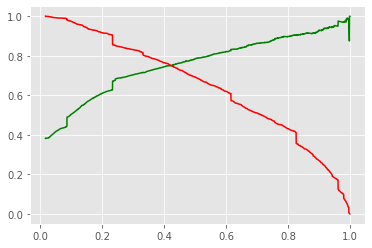

In [165]:
plt.style.use("ggplot")
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

- We can see that the cutoff is around 0.41

In [166]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.41 else 0)

y_train_pred_final.head()

,Converted,Conversion_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,1,0.692386,1,1,1,1,1,1,1,1,0,0,0,1
1,0,0.035575,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0.900289,1,1,1,1,1,1,1,1,1,1,1,1
3,1,0.233334,0,1,1,1,0,0,0,0,0,0,0,0
4,0,0.038782,0,1,0,0,0,0,0,0,0,0,0,0


In [167]:
# Current accuracy
accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.8128314798973482

In [168]:
#Current Confusion matrix
confusion2 = confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion2

array([[3071,  564],
       [ 530, 1680]])

In [169]:
TP = confusion2[1,1] # true + 
TN = confusion2[0,0] # true -
FP = confusion2[0,1] # false +
FN = confusion2[1,0] # false -

In [170]:
# Precision
TP/(TP+FP)

0.7486631016042781

In [171]:
# Recall
TP/(TP+FN)

0.7601809954751131

### Final Predictions on the Test Set

In [172]:
# Predictions on the test with the variable 'y_test_pred'
y_test_pred = res.predict(sm.add_constant(X_test))

In [173]:
y_test_pred[:5]

4924    0.335357
1797    0.479271
2781    0.086218
2294    0.131168
3869    0.100577
dtype: float64

In [174]:
#Converting y_pred to a dataframe
y_pred_1 = pd.DataFrame(y_test_pred)

In [175]:
y_pred_1.head()

,0
4924,0.335357
1797,0.479271
2781,0.086218
2294,0.131168
3869,0.100577


In [176]:
y_test_df = pd.DataFrame(y_test)

In [177]:
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [178]:
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)
y_pred_final.head()

,Converted,0
0,1,0.335357
1,0,0.479271
2,0,0.086218
3,0,0.131168
4,0,0.100577


In [179]:
y_pred_final= y_pred_final.rename(columns = {0 : 'Conversion_Prob'})

In [180]:
y_pred_final.head()

,Converted,Conversion_Prob
0,1,0.335357
1,0,0.479271
2,0,0.086218
3,0,0.131168
4,0,0.100577


In [181]:
y_pred_final['final_predicted'] = y_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.41 else 0)

In [182]:
y_pred_final.head()

,Converted,Conversion_Prob,final_predicted
0,1,0.335357,0
1,0,0.479271,1
2,0,0.086218,0
3,0,0.131168,0
4,0,0.100577,0


In [183]:
# Overall accuracy
accuracy_score(y_pred_final['Converted'], y_pred_final.final_predicted)

0.8256185155626496

In [184]:
confusion2 = confusion_matrix(y_pred_final['Converted'], y_pred_final.final_predicted )
confusion2

array([[1381,  224],
       [ 213,  688]])

In [185]:
TP = confusion2[1,1] # true + 
TN = confusion2[0,0] # true -
FP = confusion2[0,1] # false +
FN = confusion2[1,0] # false -

In [186]:
# Sensitivity
TP/(TP+FN)

0.7635960044395117

In [187]:
# Specificity
TN/(TN+FP)

0.8604361370716511

In [188]:
# Recall
TP/(TP+FN)

0.7635960044395117

In [189]:
# Precision
TP/(TP+FP)

0.7543859649122807